In [ ]:
# Dependencies
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data (FRED-MD)
df = pd.read_csv('../current.csv')

# Remove the first row (transformation codes)
transformation_codes = df.iloc[0]  # Transformation codes can be applied if needed
df = df.iloc[1:]

# Set the first column as the index and datetime
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)

# Dropna
data = df.dropna()

# Create train data and target
target = (data['CPIAUCSL'].diff(12) / data['CPIAUCSL'].shift(12)) * 100
target = target.shift(-12).dropna()
data = data.loc[target.index]
train = data.dropna()

In [ ]:
series = target.values
fp = "ar.csv"

for forecast_horizon in range(1, 53):
    for context_window in range(1, 24):
        # Split data into train and test sets
        cutoff = len(series) - forecast_horizon
        train_data = series[:cutoff]

        # Fit the AutoReg model
        model = AutoReg(train_data, lags=context_window, old_names=False)
        results = model.fit()

        # Make predictions
        forecast = results.predict(
            start=cutoff, 
            end=cutoff + forecast_horizon - 1, 
            dynamic=True # true forecasting
        )

        # Actual values
        y_true = series[-forecast_horizon:]
        y_pred = forecast[:forecast_horizon]

        # Calculate errors
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Log
        ar_log = pd.read_csv(fp) # forecast_horizon,context_window,dropout_rate,rmse,mae,forecast,true_vals
        new_row = {
            'horizon': forecast_horizon,
            'lags': context_window,
            'rmse': rmse,
            'mae': mae,
            'forecast': json.dumps(list(y_pred)),
            'actual': json.dumps(list(y_true))
        }
        ar_log = pd.concat([ar_log, pd.DataFrame([new_row])], ignore_index=True)
        ar_log.to_csv(fp, index=False)

                            OLS Regression Results                            
Dep. Variable:                   rmse   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1934.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:35:09   Log-Likelihood:                -914.92
No. Observations:                1196   AIC:                             1838.
Df Residuals:                    1192   BIC:                             1858.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5494      0.063     -8.697      

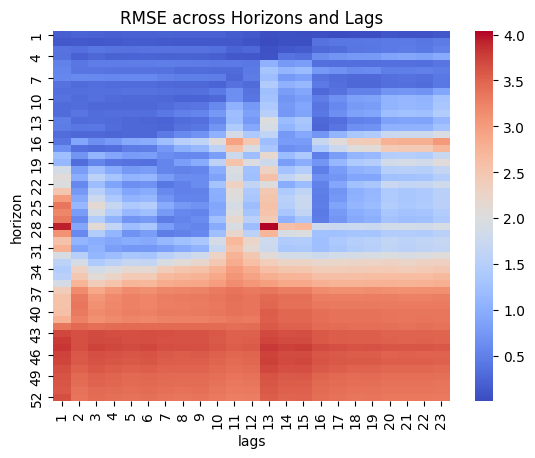

In [30]:
# Look at minimum RMSE per horizon
import pandas as pd
data = pd.read_csv("ar.csv")[["horizon", "lags", "rmse"]]

correlation = data.corr(method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt
pivot = data.pivot(index='horizon', columns='lags', values='rmse')
sns.heatmap(pivot, annot=False, cmap='coolwarm')
plt.title("RMSE across Horizons and Lags")

import statsmodels.formula.api as smf
data['interaction'] = data['horizon'] * data['lags']
model = smf.ols("rmse ~ horizon + lags + interaction", data=data).fit()
print(model.summary())

# Get the minimum RMSE for each forecast horizon
min_rmse = data.groupby('horizon')['rmse'].min().reset_index()
# Merge with original data to get the context window
min_rmse = min_rmse.merge(data, on=['horizon', 'rmse'])
# min_rmse

In [31]:
import pandas as pd
data = pd.read_csv("ar.csv")[["horizon", "lags", "rmse"]]

# Average RMSE accross all horizons for each lag
avg_rmse = data.groupby('lags')['rmse'].mean().reset_index()
avg_rmse.describe()

,lags,rmse
count,23.00000,23.000000
mean,12.00000,1.852679
std,6.78233,0.214828
min,1.00000,1.593193
25%,6.50000,1.645470
50%,12.00000,1.856688
75%,17.50000,1.999234
max,23.00000,2.364542
